## Introduction

This notebook was developed during the coursework of CS 4774 Machine Learning in the Department of Computer Science at the University of Virginia.

In this notebook, I will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, I will attempt to predict the medical cost billed by health insurance using other provided patient's data.


***
##  Step 1: The Big Picture
I will first detail the context of the problem in which I am trying to investigate. I will assume that the data file is put into the same workspace on Colab. Then, I will write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is the dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics I can learn right away about this dataset?

In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
import random


# To make this notebook's output stable across runs
np.random.seed(42)

# Code goes here for this section, make sure it also includes the output to answer the above questions.

# The context of this problem is the medical insurance market. I will be looking at the medical costs billed by health insurance companies and other agents. I will be attempting to predict charges based on the information of people from a dataset.

# 1. The dataset is 0.055 MB
# 2. The dataset has 1338 entries
# 3. The dataset has 7 features
# 4. The dataset does contain categorical data such as gender, smoker status, and region
# 5. The values look good, there are some outliers but no null values (see output)
# 6. Smokers increase charges drastically, charges increase slowly as you get older etc. (see charts below)

url = "https://raw.githubusercontent.com/lpg0/ml_hw/main/insurance.csv"
data = pd.read_csv(url)

#imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#data = imp.fit_transform(data)

data.plot(kind='scatter', x='age', y='bmi')
data.plot(kind='scatter', x='age', y='charges')
data.plot(kind='scatter', x='bmi', y='charges')

data_smoker = data.groupby("smoker").agg([np.mean, np.std])
data_charges = data_smoker['charges']

print(data.isna().sum())

data_charges.plot(kind = "barh", y = "mean", legend = False,
            title = "Average Charges if Smoking")

HTTPError: HTTP Error 404: Not Found

---
##  Step 2: Data Discovery, Cleaning, & Scaling

**Data Discovery:** Plot out all correlations among the features. I should notice some features are more correlated with the predicted value than others. This information will help confirm the weights of regression model later on.

**Data Cleaning:** If the dataset has some missing values, make sure it is possible to fill those values with the Imputer class. If the dataset has categorical features, make sure it is possible to confer those features into numerical using OneHotEncoder class.

**Feature Scaling** More importantly, the task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** I will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [ ]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector as selector

# Code goes here for this section.

data.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
data.info

<bound method DataFrame.info of       age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]>

In [ ]:
data["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [ ]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


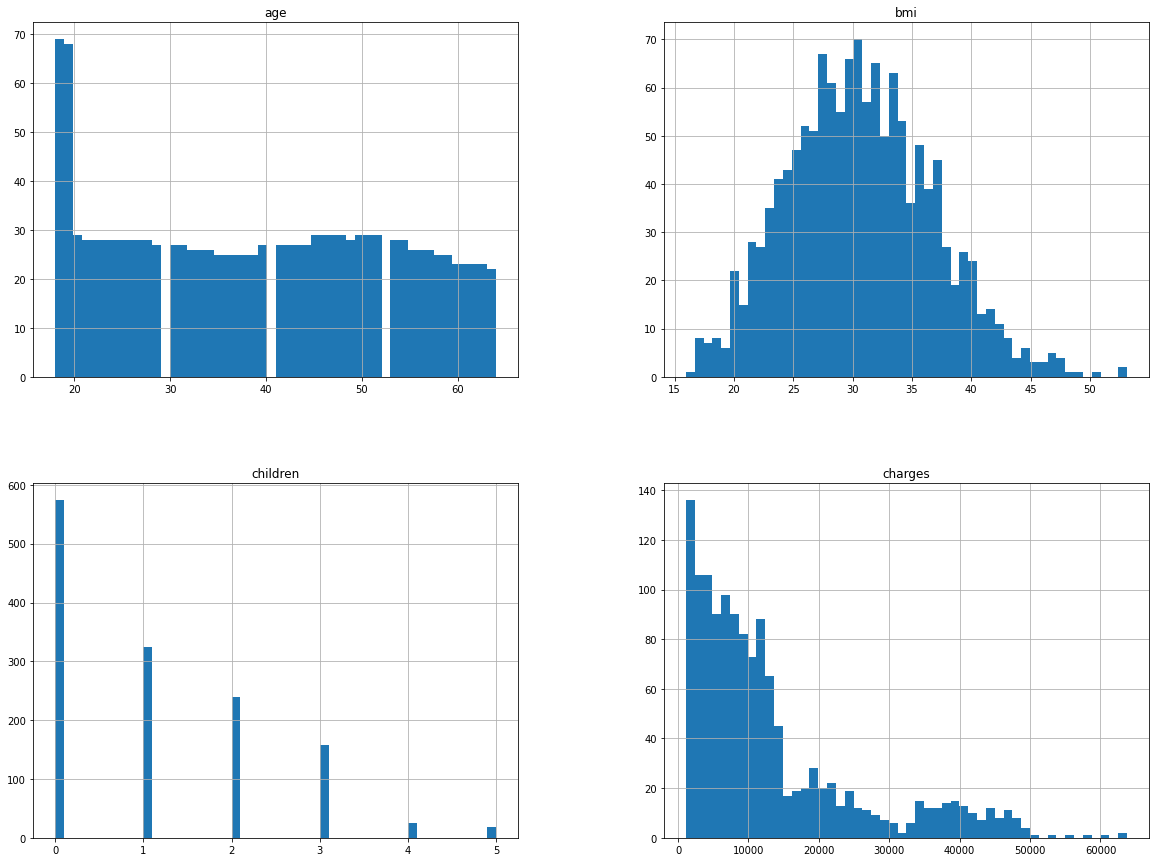

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

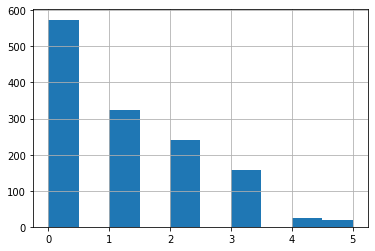

In [ ]:
data["children"].hist()

In [ ]:
data_sx = data[["sex"]]
data_sm = data[["smoker"]]
data_rg = data[["region"]]
data_ag = data[["age"]]
data_bm = data[["bmi"]]
data_ca = data[["charges"]]
data_ci = data[["children"]]

In [ ]:
data_encoder = OneHotEncoder(sparse=False)

In [ ]:
data_sx_1hot = data_encoder.fit_transform(data_sx)
data_sx_1hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
data_sx_1hot = data_encoder.fit_transform(data_sm)
data_sx_1hot

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]])

In [ ]:
data_sx_1hot = data_encoder.fit_transform(data_rg)
data_sx_1hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
scaler = StandardScaler()

In [ ]:
scaled_ag = scaler.fit_transform(data_ag)
scaled_bm = scaler.fit_transform(data_bm)
scaled_ca = scaler.fit_transform(data_ca)
scaled_ci = scaler.fit_transform(data_ci)
scaled_ag


array([[-1.43876426],
       [-1.50996545],
       [-0.79795355],
       ...,
       [-1.50996545],
       [-1.29636188],
       [ 1.55168573]])

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
y_train = train_set["charges"]
y_test = test_set["charges"]
x_train = train_set.drop("charges", 1)
x_test = test_set.drop("charges", 1)

In [ ]:
type(x_train)

pandas.core.frame.DataFrame

In [ ]:
first_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("cat", StandardScaler())
    ])

In [ ]:
second_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat", OneHotEncoder(sparse=False))
    ])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
full_pipeline = ColumnTransformer([
        ('num', first_pipeline, selector(dtype_exclude="object")),
        ('cat', second_pipeline, selector(dtype_include="object"))
    ])

data_pipe = full_pipeline.fit_transform(data)

In [ ]:
x_train = full_pipeline.fit_transform(x_train)
x_train.shape

(1070, 11)

In [ ]:
x_train.astype('float64')

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.54331294, -1.03308239, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8987451 , -0.94368672, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16755139,  2.82086429,  0.73433626, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.1120044 , -0.10932713, -0.91119211, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
x_test = full_pipeline.fit_transform(x_test)
x_test.shape

(268, 11)

In [ ]:
x_test.astype('float64')

array([[ 0.45859585, -0.93715188,  0.82250933, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18713281, -0.16752679, -0.89961958, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.82180078, -0.66551949, -0.89961958, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.04363755, -0.48443124, -0.03855512, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.1043245 ,  2.59486336, -0.89961958, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.88908162,  0.49646348, -0.03855512, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
y_train

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
           ...     
1095     4561.18850
1130     8582.30230
1294    11931.12525
860     46113.51100
1126    10214.63600
Name: charges, Length: 1070, dtype: float64

In [ ]:
y_train = y_train.values
y_train

array([ 9193.8385 ,  8534.6718 , 27117.99378, ..., 11931.12525,
       46113.511  , 10214.636  ])

In [ ]:
y_test

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
109     47055.53210
575     12222.89830
535      6067.12675
543     63770.42801
846      9872.70100
Name: charges, Length: 268, dtype: float64

In [ ]:
y_test = y_test.values
y_test

array([ 9095.06825 ,  5272.1758  , 29330.98315 ,  9301.89355 ,
       33750.2918  ,  4536.259   ,  2117.33885 , 14210.53595 ,
        3732.6251  , 10264.4421  , 18259.216   ,  7256.7231  ,
        3947.4131  , 46151.1245  , 48673.5588  , 44202.6536  ,
        9800.8882  , 42969.8527  ,  8233.0975  , 21774.32215 ,
        5080.096   ,  7441.501   ,  1256.299   ,  2755.02095 ,
       11085.5868  , 10923.9332  , 12644.589   , 18804.7524  ,
        9715.841   ,  1131.5066  , 15828.82173 , 11842.62375 ,
        2020.5523  ,  5693.4305  ,  2904.088   ,  7448.40395 ,
        2597.779   ,  7337.748   , 23887.6627  , 38709.176   ,
        4687.797   ,  2643.2685  , 11674.13    , 12124.9924  ,
        4889.9995  , 12333.828   ,  3579.8287  ,  4391.652   ,
       42124.5153  ,  4463.2051  , 13887.204   ,  1719.4363  ,
       28476.73499 ,  1708.92575 , 10594.2257  , 25333.33284 ,
        3645.0894  , 38746.3551  , 11848.141   , 10564.8845  ,
       13880.949   ,  4753.6368  , 27941.28758 ,  8017.

In [ ]:
x_train

array([[ 0.47222651, -1.75652513,  0.73433626, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.54331294, -1.03308239, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8987451 , -0.94368672, -0.91119211, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.3252637 , -0.89153925, -0.91119211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.16755139,  2.82086429,  0.73433626, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.1120044 , -0.10932713, -0.91119211, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
z = np.ones((len(x_train),1), dtype='float64')
w = np.ones((len(x_test),1), dtype='float64')

In [ ]:
z

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
x_train = np.append(x_train, z, axis=1)

In [ ]:
x_test = np.append(x_test, w, axis=1)

In [ ]:
y_train = np.reshape(y_train, (1070,1))

In [ ]:
y_train.shape

(1070, 1)

- - -
## Step 3: Implement Gradient Descent
I will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. Code should be written to implement the **MyLinearRegression** class and its predefined methods.

**Gradient Descent:** Note that is NOT best practice to call the library linear regression which defeats the purpose. The data should be well-vectorized.

In [ ]:
import math

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, x_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT:
    theta: updated value for theta
    cost: value of the cost function
    """
    m = len(y_train)
    alpha = 0.25
    iters = 100
    theta = np.random.randn(len(x_train[0]),1)
    cost = []
    #print(theta)
    # implementation code here
    for iteration in range(iters):
      gradients = 2/m * np.dot(np.transpose(x_train), np.dot(x_train, theta) - y_train)
      theta = theta - alpha * gradients
      cost.append((1/m * np.dot(np.transpose(np.dot(x_train, theta) - y_train),np.dot(x_train, theta) - y_train))[0])
    return theta, cost

  def fitUsingGradientDescent(self, x_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here
    self.theta, self.cost = self.gradientDescent(x_train, y_train, self.theta, self.alpha, 1000)

  def fitUsingNormalEquation(self, x_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    m = len(y_train)
    self.cost.append([])
    self.theta = np.dot(np.linalg.pinv(x_train),y_train)
    self.cost[0].append(1/m * np.dot(np.transpose(np.dot(x_train, self.theta) - y_train),np.dot(x_train, self.theta) - y_train))

  def predict(self, x_test):
    """
    Predicting the label
    """
    # implementation code here
    return np.dot(x_test, self.theta)

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    return("Parameter vector is %f" % self.theta)

# code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.fitUsingGradientDescent(x_train, y_train)
print(math.sqrt(myGradientDescentModel.cost[-1][-1]))

6105.5451601108725


* **Learning Rate:** I will try out different learning rates for the dataset and find a learning rate that converges quickly. If a learning rate is picked, the plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that the implementation is correct. If the learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, I must be able to report the best learning rate found.

No handles with labels found to put in legend.


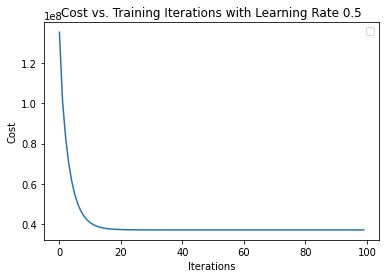

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(100), myGradientDescentModel.cost)

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Training Iterations with Learning Rate 0.5')

plt.legend()

No handles with labels found to put in legend.


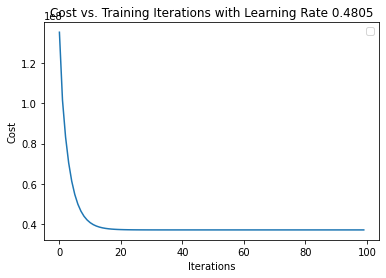

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(100), myGradientDescentModel.cost)

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Training Iterations with Learning Rate 0.4805')

plt.legend()

No handles with labels found to put in legend.


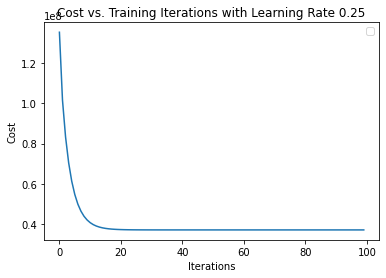

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(100), myGradientDescentModel.cost)

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Training Iterations with Learning Rate 0.25')

plt.legend()

No handles with labels found to put in legend.


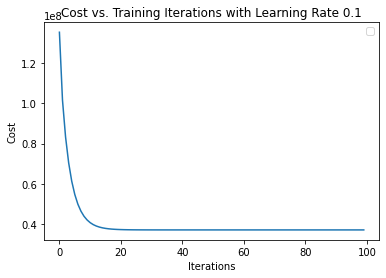

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(100), myGradientDescentModel.cost)

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Training Iterations with Learning Rate 0.1')

plt.legend()

The best is 0.25 due to the rmse and curve

- - -
## Step 4: Implement the Normal Equation

The closed form solution of linear regression can be found using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement:

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that I still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [ ]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(x_train, y_train)
print(math.sqrt(myNormalEquationModel.cost[-1][-1]))

6105.545160099847


- - -
## Step 5: Compare Different Implementations

I should be able to evaluate and compare my gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measure, I will use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, I will compute the RMSE on the **test set** as performance measure. The good news is that I can call library functions to compute these as shown below instead of writing my own code:

* Which one yields the best performance measure for the dataset?
* What is the assessment of the error? Good? Okay? Terrible?

In [ ]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(x_train,y_train)
y_predict = mySGDModel.predict(x_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print(mySGDModel_rmse)

y_predict1 = myGradientDescentModel.predict(x_test)
mse1 = mean_squared_error(y_test, y_predict1)
print(math.sqrt(mse1))
y_predict2 = myNormalEquationModel.predict(x_test)
mse2 = mean_squared_error(y_test, y_predict2)
print(math.sqrt(mse2))



5798.636782587426
5795.334119704174
5798.636782587426


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- - -
## Step 6: The Solution

Now I will write a short memo of one paragraph to be read by a non-technical audience (ie. a manager/boss), answering the following questions:

* How could this solution be pitched?
* What was learned so far about the problem?
* Are there any insights moving forward to improve the solution?

In [ ]:
# This solution could be pitched by reviewing the context of the problem then explaining the low error of the prediction model. I learned that linear regression is a reasonable method to predict medical charges. Further improvements could be made by considering other algorithms such as random forest and decision tree.